<a href="https://colab.research.google.com/github/azycr4yy/DDPM/blob/main/DIFFUSIONMODEL_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("subinium/emojiimage-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emojiimage-dataset


In [2]:
import kagglehub
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [4]:
from google.colab import files
files.upload()

{}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d subinium/emojiimage-dataset

Dataset URL: https://www.kaggle.com/datasets/subinium/emojiimage-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/47.6M [00:00<?, ?B/s]
100% 47.6M/47.6M [00:00<00:00, 973MB/s]


In [7]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -o emojiimage-dataset.zip -d emoji_dataset;

In [8]:
!unzip -q celeba-dataset.zip -d img_align_celeba


replace img_align_celeba/img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace img_align_celeba/img_align_celeba/img_align_celeba/000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n


In [3]:
import os

print(os.listdir("img_align_celeba")[:5])


FileNotFoundError: [Errno 2] No such file or directory: 'img_align_celeba'

In [10]:
import pandas as pd
df = pd.read_csv('emoji_dataset/full_emoji.csv')
df.head()
df = df['name']

FileNotFoundError: [Errno 2] No such file or directory: 'emoji_dataset/full_emoji.csv'

In [11]:
import pandas as pd
import os
data = []
for root, dirs, files in os.walk("img_align_celeba"):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg'):
            path = os.path.join(root, file)
            data.append({'path': path})
path_data_base = pd.DataFrame(data)

In [12]:
from torch.utils.data import Dataset
from PIL import Image
class EmojiDataset(Dataset):
  def __init__(self,dataframe,transform):
    self.dataframe=dataframe
    self.transform=transform
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self,idx):
    img_path = self.dataframe.iloc[idx]["path"]
    img = Image.open(img_path)
    if img.mode == 'P':
      img = img.convert('RGB')
    else:
      img = img.convert('RGB')
    if self.transform:
      img = self.transform(img)
    return img

In [13]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
from torch.utils.data import DataLoader
from torchvision import transforms
transform = transforms.Compose([
    transforms.CenterCrop(64),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
data = EmojiDataset(path_data_base,transform)
dataloader = DataLoader(data,batch_size=2,shuffle=True)

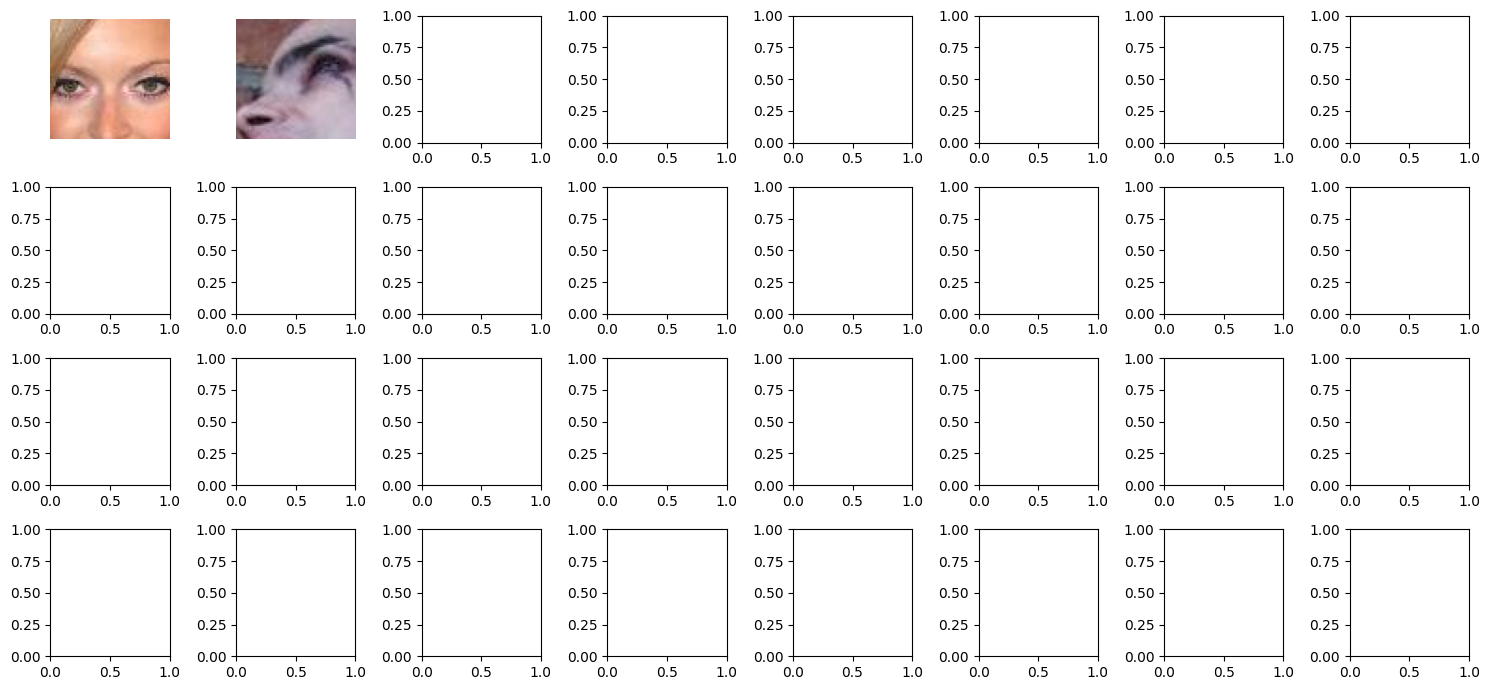

In [15]:
#display training batch images
import matplotlib.pyplot as plt
import numpy as np
images = next(iter(dataloader))
images = images * 0.5 + 0.5
fig, axes = plt.subplots(4, 8, figsize=(15, 7))
for i, ax in enumerate(axes.flat):
    if i < images.shape[0]:
        ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        ax.axis('off')
plt.tight_layout()
plt.show()

In [16]:
import torch
from torch import nn
class NoiseScheduler():
  def __init__(self,betas_start,betas_end,num_time_steps) -> None:
    self.betas_start = betas_start
    self.betas_end = betas_end
    self.num_time_steps = num_time_steps
    self.beta = torch.linspace(self.betas_start,self.betas_end,self.num_time_steps)
    self.alpha = 1 - self.beta
    self.alpha_bar = torch.cumprod(self.alpha,dim=0)
    self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
    self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
  def add_noise(self,img,noise,t):
    img_shape = img.shape
    batch_size = img_shape[0]

    sqrt_alpha_bar = self.sqrt_alpha_bar.to(img.device, dtype=img.dtype)[t].reshape(batch_size)
    sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar.to(img.device, dtype=img.dtype)[t].reshape(batch_size)
    for _ in range(len(img_shape)-1):
      sqrt_alpha_bar = sqrt_alpha_bar.unsqueeze(-1)
      sqrt_one_minus_alpha_bar = sqrt_one_minus_alpha_bar.unsqueeze(-1)
    return sqrt_alpha_bar * img + sqrt_one_minus_alpha_bar * noise
  def sample_prev_timestep(self,xt,noise_prod,t):
    x0 = (xt-self.sqrt_one_minus_alpha_bar[t]*noise_prod)/self.sqrt_alpha_bar[t]
    x0 = torch.clamp(x0,min=-1,max=1)
    mean = xt-(self.beta[t]*noise_prod)/self.sqrt_one_minus_alpha_bar[t]
    mean = mean/self.sqrt_alpha_bar[t]
    if t==0:
      return mean,x0
    else:
      variance = (self.alpha[t])*(self.sqrt_one_minus_alpha_bar[t-1])
      variance = variance/self.sqrt_one_minus_alpha_bar[t]
      sigma = variance **0.5
      noise = torch.randn_like(xt).to(device)
      return mean+noise*sigma,x0

In [17]:
def get_time_emb(time_steps,time_emd_dim):
  time_steps=time_steps.float()
  half_dim = time_emd_dim // 2
  freqs = torch.exp(-torch.arange(half_dim, device=time_steps.device, dtype=time_steps.dtype).float() *
                      torch.log(torch.tensor(10000.0, device=time_steps.device, dtype=time_steps.dtype)) / (half_dim - 1))
  args = time_steps[:, None] * freqs[None, :]
  t_emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
  return t_emb

In [18]:
class DownBlock(nn.Module):
  def __init__(self,in_channels,out_channels,num_heads,t_emb_dim,down_sample) -> None:
    super().__init__()
    self.down_sample = down_sample
    self.first_conv_resnet = nn.Sequential(
        nn.GroupNorm(8,in_channels),
        nn.SiLU(),
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=1)
    )
    self.t_emb_layer = nn.Sequential(
        nn.SiLU(),
        nn.Linear(t_emb_dim,out_channels)
    )
    self.second_conv_conv = nn.Sequential(
        nn.GroupNorm(8,out_channels),
        nn.SiLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,stride=1)
    )
    self.down_Sampler = nn.Conv2d(out_channels,out_channels,kernel_size=4,stride=2,padding=1)
    self.attention_norm = nn.GroupNorm(8,out_channels)
    self.MultiHeadAttentionm = nn.MultiheadAttention(num_heads=num_heads,embed_dim=out_channels)
    self.residual_input_conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1)

  def forward(self,x,t_emb):
    out = x
    resnet_input = x
    out = self.first_conv_resnet(out)
    out = out + self.t_emb_layer(t_emb)[:,:,None,None]
    out = self.second_conv_conv(out)
    out = out + self.residual_input_conv(resnet_input)

    batch_size , channels , h , w = out.shape
    in_attn = out
    in_attn = in_attn.reshape(batch_size,channels,h*w)
    in_attn = self.attention_norm(in_attn)
    in_attn = in_attn.transpose(1,2)
    out_attn , _ = self.MultiHeadAttentionm(in_attn,in_attn,in_attn)
    out_attn = out_attn.transpose(1,2).reshape(batch_size,channels,h,w)
    out = out_attn + out
    if self.down_sample:
      out = self.down_Sampler(out)
    return out

In [19]:
class MiddleBlock(nn.Module):
  def __init__(self, in_channels,out_channels,t_emb_dim,num_heads) -> None:
    super().__init__()
    self.resenet_conv_first = nn.Sequential(
        nn.GroupNorm(8,in_channels),
        nn.SiLU(),
        nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1)
    )
    self.t_emb_layer = nn.Sequential(
        nn.SiLU(),
        nn.Linear(t_emb_dim,out_channels)
    )
    self.resenet_conv_second = nn.Sequential(
        nn.GroupNorm(8,out_channels),
        nn.SiLU(),
        nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1)
    )
    self.attention_norm = nn.GroupNorm(8,out_channels)
    self.attentiion = nn.MultiheadAttention(out_channels,num_heads,batch_first=True)
    self.residual_input = nn.ModuleList([
        nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1),
        nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1)
    ])
  def forward(self,x,t_emb):
    out = x
    resnet_input = out
    out = self.resenet_conv_first(out)
    out = out + self.t_emb_layer(t_emb)[:,:,None,None]
    out = self.resenet_conv_second(out)
    out = out + self.residual_input[0](resnet_input)

    batch_size , channels , h , w = out.shape
    in_attn = out.reshape(batch_size,channels,h*w)
    in_attn = self.attention_norm(in_attn)
    in_attn = in_attn.transpose(1,2)
    out_attn , _ = self.attentiion(in_attn,in_attn,in_attn)
    out_attn = out_attn.transpose(1,2).reshape(batch_size,channels,h,w)
    out = out_attn + out

    return out

In [26]:
class ResnetBlock(nn.Module):
  def __init__(self,in_channels,out_channels,t_emb_dim,num_heads=4) -> None:
    super().__init__()
    self.norm1 = nn.GroupNorm(8,in_channels)
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1)
    self.norm2 = nn.GroupNorm(8,out_channels)
    self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1)
    self.t_emb_layer = nn.Sequential(
        nn.SiLU(),
        nn.Linear(t_emb_dim,out_channels)
    )
    if in_channels != out_channels:
      self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    else:
      self.residual_conv = nn.Identity()

  def forward(self,x,t_emb):
    residual = x
    out = self.norm1(x)
    out = nn.SiLU()(out)
    out = self.conv1(out)
    out = out + self.t_emb_layer(t_emb)[:,:,None,None]
    out = self.norm2(out)
    out = nn.SiLU()(out)
    out = self.conv2(out)
    out = out + self.residual_conv(residual)
    return out

In [25]:
class UpSampler(nn.Module):
    def __init__(self, in_channels, out_channels,skip_channels, num_heads, t_emb_dim) -> None:
        super().__init__()

        self.upsample = nn.Upsample(mode="bilinear",scale_factor=2)
        self.conv = nn.Conv2d(in_channels=in_channels,out_channels=in_channels,kernel_size=3,padding=1,stride=1)

        total_channels = in_channels + skip_channels
        self.resnet = ResnetBlock(total_channels, out_channels, t_emb_dim)

        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

    def forward(self, x, out_down, t_emb):

        x_upsampled = self.upsample(x)
        x_upsampled = self.conv(x_upsampled)

        x_concat = torch.cat([x_upsampled, out_down], dim=1)

        out = self.resnet(x_concat, t_emb)

        batch_size, channels, h, w = out.shape
        in_attn = out.reshape(batch_size, channels, h * w)
        in_attn = self.attention_norm(in_attn)
        in_attn = in_attn.transpose(1, 2)
        out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        out = out_attn + out

        return out

In [24]:
class Unet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.down_channels = [32, 64, 128, 256]
        self.up_channels = [256, 128, 64, 32]
        self.t_emb_dim = 128
        self.down_sample = [True, True, True, False]

        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.conv_in = nn.Conv2d(in_channels=in_channels, out_channels=self.down_channels[0],
                                kernel_size=3, padding=1, stride=1)

        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.downs.append(
                DownBlock(in_channels=self.down_channels[i],
                         out_channels=self.down_channels[i + 1],
                         num_heads=4,
                         t_emb_dim=self.t_emb_dim,
                         down_sample=self.down_sample[i])
            )

        self.mids = nn.ModuleList([
            MiddleBlock(in_channels=256, out_channels=256, t_emb_dim=self.t_emb_dim, num_heads=4),
            MiddleBlock(in_channels=256, out_channels=256, t_emb_dim=self.t_emb_dim, num_heads=4)
        ])

        self.ups = nn.ModuleList([])
        for i in range(len(self.up_channels) - 1):
          skip_index = len(self.up_channels)-2-i
          skip_channel = self.down_channels[skip_index]
          self.ups.append(
              UpSampler(in_channels=self.up_channels[i],
                        out_channels=self.up_channels[i + 1],
                        skip_channels=skip_channel,
                        num_heads=4,
                        t_emb_dim=self.t_emb_dim)
          )

        self.norm_out = nn.GroupNorm(8, 32)
        self.conv_out = nn.Conv2d(32, in_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        out = self.conv_in(x)

        t_emb = get_time_emb(t, self.t_emb_dim)
        t_emb = t_emb.to(x.dtype)
        t_emb = self.t_proj(t_emb)

        down_outs = []
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)

        for mid in self.mids:
            out = mid(out, t_emb)

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)

        out = nn.SiLU()(self.norm_out(out))
        out = self.conv_out(out)

        return out

In [20]:
pip install bitsandbytes

KeyboardInterrupt: 

In [22]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import os


def train_diffusion_model(model, dataloader, noise_scheduler, num_epochs=100, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    from bitsandbytes.optim import AdamW8bit
    optimizer = AdamW8bit(model.parameters(), lr=learning_rate)
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch_idx, images in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images = images.half().to(device)
            batch_size = images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.num_time_steps, (batch_size,), device=device)
            noise = torch.randn_like(images)
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            predicted_noise = model(noisy_images, timesteps)
            loss = F.mse_loss(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

        model.eval()
        with torch.no_grad():
            generated = sample_from_diffusion(
                model, noise_scheduler,
                img_shape=(3, 64, 64),
                num_steps=noise_scheduler.num_time_steps,
                device=device
            )
            img = generated.squeeze().permute(1, 2, 0).cpu().numpy()
            plt.figure(figsize=(2, 2))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Generated Sample - Epoch {epoch+1}")
            plt.show()
        model.train()
    return losses


def sample_from_diffusion(model, noise_scheduler, img_shape=(3, 32, 32), num_steps=1000, device=None):
    import torch

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    x = torch.randn(1, *img_shape, device=device, dtype=torch.float16)

    for t in tqdm(reversed(range(num_steps)), desc="Sampling"):
        time_steps = torch.full((1,), t, device=device, dtype=torch.long)
        with torch.no_grad():
            pred_noise = model(x, time_steps)

        alpha_t = noise_scheduler.alpha[t].to(device, dtype=x.dtype)
        alpha_bar_t = noise_scheduler.alpha_bar[t].to(device, dtype=x.dtype)
        beta_t = noise_scheduler.beta[t].to(device, dtype=x.dtype)
        sqrt_one_minus_alpha_bar_t = noise_scheduler.sqrt_one_minus_alpha_bar[t].to(device, dtype=x.dtype)

        coef1 = 1 / torch.sqrt(alpha_t)
        coef2 = beta_t / sqrt_one_minus_alpha_bar_t
        x_prev_mean = coef1 * (x - coef2 * pred_noise)

        if t > 0:
            noise = torch.randn_like(x)
            var_t = beta_t
            x = x_prev_mean + torch.sqrt(var_t) * noise
        else:
            x = x_prev_mean

    x = x.clamp(-1, 1).float()
    x = (x + 1) / 2
    return x.cpu()



def run_training():
    model = Unet(in_channels=3).half()
    noise_scheduler = NoiseScheduler(betas_start=1e-4, betas_end=0.02, num_time_steps=250)
    losses = train_diffusion_model(
        model=model,
        dataloader=dataloader,
        noise_scheduler=noise_scheduler,
        num_epochs=70,
        learning_rate=1e-4
    )
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    generated = sample_from_diffusion(model, noise_scheduler, img_shape=(3, 32, 32), num_steps=1000)
    grid_img = generated.squeeze().permute(1, 2, 0).numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(grid_img)
    plt.axis('off')
    plt.title('Generated Emoji Image')
    plt.show()


In [2]:
run_training()

NameError: name 'run_training' is not defined